# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4317184/11490434 [==========>...................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:57 - loss: 0.6935

  34/1875 [..............................] - ETA: 2s - loss: 0.5285   

  66/1875 [>.............................] - ETA: 2s - loss: 0.4529

  95/1875 [>.............................] - ETA: 2s - loss: 0.4162

 128/1875 [=>............................] - ETA: 2s - loss: 0.3887

 160/1875 [=>............................] - ETA: 2s - loss: 0.3695

 193/1875 [==>...........................] - ETA: 2s - loss: 0.3541

 224/1875 [==>...........................] - ETA: 2s - loss: 0.3422

 254/1875 [===>..........................] - ETA: 2s - loss: 0.3324

 280/1875 [===>..........................] - ETA: 2s - loss: 0.3249

 309/1875 [===>..........................] - ETA: 2s - loss: 0.3175

 335/1875 [====>.........................] - ETA: 2s - loss: 0.3114

 363/1875 [====>.........................] - ETA: 2s - loss: 0.3055

 399/1875 [=====>........................] - ETA: 2s - loss: 0.2987

 435/1875 [=====>........................] - ETA: 2s - loss: 0.2925

 470/1875 [======>.......................] - ETA: 2s - loss: 0.2870

 505/1875 [=======>......................] - ETA: 2s - loss: 0.2821

 540/1875 [=======>......................] - ETA: 2s - loss: 0.2775

 575/1875 [========>.....................] - ETA: 2s - loss: 0.2732

 609/1875 [========>.....................] - ETA: 2s - loss: 0.2694

 644/1875 [=========>....................] - ETA: 1s - loss: 0.2657

 678/1875 [=========>....................] - ETA: 1s - loss: 0.2624

 708/1875 [==========>...................] - ETA: 1s - loss: 0.2596

 740/1875 [==========>...................] - ETA: 1s - loss: 0.2567

 775/1875 [===========>..................] - ETA: 1s - loss: 0.2538

 807/1875 [===========>..................] - ETA: 1s - loss: 0.2512

 836/1875 [============>.................] - ETA: 1s - loss: 0.2490

 856/1875 [============>.................] - ETA: 1s - loss: 0.2475

 883/1875 [=============>................] - ETA: 1s - loss: 0.2456

 909/1875 [=============>................] - ETA: 1s - loss: 0.2438

 934/1875 [=============>................] - ETA: 1s - loss: 0.2421

 963/1875 [==============>...............] - ETA: 1s - loss: 0.2403

 991/1875 [==============>...............] - ETA: 1s - loss: 0.2385

1018/1875 [===============>..............] - ETA: 1s - loss: 0.2369

1044/1875 [===============>..............] - ETA: 1s - loss: 0.2354

1073/1875 [================>.............] - ETA: 1s - loss: 0.2337

1095/1875 [================>.............] - ETA: 1s - loss: 0.2325

1120/1875 [================>.............] - ETA: 1s - loss: 0.2312

1148/1875 [=================>............] - ETA: 1s - loss: 0.2297

1172/1875 [=================>............] - ETA: 1s - loss: 0.2285

1199/1875 [==================>...........] - ETA: 1s - loss: 0.2272

1223/1875 [==================>...........] - ETA: 1s - loss: 0.2260

1247/1875 [==================>...........] - ETA: 1s - loss: 0.2249

1275/1875 [===================>..........] - ETA: 1s - loss: 0.2236

1302/1875 [===================>..........] - ETA: 0s - loss: 0.2224

1331/1875 [====================>.........] - ETA: 0s - loss: 0.2211

1355/1875 [====================>.........] - ETA: 0s - loss: 0.2201

1378/1875 [=====================>........] - ETA: 0s - loss: 0.2192

1403/1875 [=====================>........] - ETA: 0s - loss: 0.2182

1428/1875 [=====================>........] - ETA: 0s - loss: 0.2172

1453/1875 [======================>.......] - ETA: 0s - loss: 0.2162

1477/1875 [======================>.......] - ETA: 0s - loss: 0.2153

1505/1875 [=======================>......] - ETA: 0s - loss: 0.2142

1534/1875 [=======================>......] - ETA: 0s - loss: 0.2132

1562/1875 [=======================>......] - ETA: 0s - loss: 0.2122

1590/1875 [========================>.....] - ETA: 0s - loss: 0.2112

1617/1875 [========================>.....] - ETA: 0s - loss: 0.2103

1645/1875 [=========================>....] - ETA: 0s - loss: 0.2093

1674/1875 [=========================>....] - ETA: 0s - loss: 0.2084

1702/1875 [==========================>...] - ETA: 0s - loss: 0.2075

1730/1875 [==========================>...] - ETA: 0s - loss: 0.2066

1757/1875 [===========================>..] - ETA: 0s - loss: 0.2058

1784/1875 [===========================>..] - ETA: 0s - loss: 0.2050

1813/1875 [============================>.] - ETA: 0s - loss: 0.2041

1842/1875 [============================>.] - ETA: 0s - loss: 0.2033

1871/1875 [============================>.] - ETA: 0s - loss: 0.2024

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2023


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1175

  29/1875 [..............................] - ETA: 3s - loss: 0.1137

  57/1875 [..............................] - ETA: 3s - loss: 0.1124

  88/1875 [>.............................] - ETA: 3s - loss: 0.1119

 120/1875 [>.............................] - ETA: 3s - loss: 0.1116

 148/1875 [=>............................] - ETA: 3s - loss: 0.1114

 176/1875 [=>............................] - ETA: 2s - loss: 0.1112

 205/1875 [==>...........................] - ETA: 2s - loss: 0.1111

 232/1875 [==>...........................] - ETA: 2s - loss: 0.1110

 260/1875 [===>..........................] - ETA: 2s - loss: 0.1108

 287/1875 [===>..........................] - ETA: 2s - loss: 0.1107

 315/1875 [====>.........................] - ETA: 2s - loss: 0.1106

 342/1875 [====>.........................] - ETA: 2s - loss: 0.1105

 370/1875 [====>.........................] - ETA: 2s - loss: 0.1104

 397/1875 [=====>........................] - ETA: 2s - loss: 0.1102

 425/1875 [=====>........................] - ETA: 2s - loss: 0.1101

 447/1875 [======>.......................] - ETA: 2s - loss: 0.1100

 478/1875 [======>.......................] - ETA: 2s - loss: 0.1099

 507/1875 [=======>......................] - ETA: 2s - loss: 0.1098

 529/1875 [=======>......................] - ETA: 2s - loss: 0.1097

 552/1875 [=======>......................] - ETA: 2s - loss: 0.1096

 577/1875 [========>.....................] - ETA: 2s - loss: 0.1095

 602/1875 [========>.....................] - ETA: 2s - loss: 0.1095

 630/1875 [=========>....................] - ETA: 2s - loss: 0.1094

 658/1875 [=========>....................] - ETA: 2s - loss: 0.1093

 683/1875 [=========>....................] - ETA: 2s - loss: 0.1092

 710/1875 [==========>...................] - ETA: 2s - loss: 0.1091

 735/1875 [==========>...................] - ETA: 2s - loss: 0.1090

 763/1875 [===========>..................] - ETA: 2s - loss: 0.1090

 792/1875 [===========>..................] - ETA: 2s - loss: 0.1089

 820/1875 [============>.................] - ETA: 1s - loss: 0.1088

 842/1875 [============>.................] - ETA: 1s - loss: 0.1087

 868/1875 [============>.................] - ETA: 1s - loss: 0.1087

 895/1875 [=============>................] - ETA: 1s - loss: 0.1086

 920/1875 [=============>................] - ETA: 1s - loss: 0.1085

 945/1875 [==============>...............] - ETA: 1s - loss: 0.1085

 968/1875 [==============>...............] - ETA: 1s - loss: 0.1084

 997/1875 [==============>...............] - ETA: 1s - loss: 0.1083

1025/1875 [===============>..............] - ETA: 1s - loss: 0.1083

1052/1875 [===============>..............] - ETA: 1s - loss: 0.1082

1076/1875 [================>.............] - ETA: 1s - loss: 0.1081

1104/1875 [================>.............] - ETA: 1s - loss: 0.1081

1125/1875 [=================>............] - ETA: 1s - loss: 0.1080

1154/1875 [=================>............] - ETA: 1s - loss: 0.1079

1184/1875 [=================>............] - ETA: 1s - loss: 0.1079

1214/1875 [==================>...........] - ETA: 1s - loss: 0.1078

1245/1875 [==================>...........] - ETA: 1s - loss: 0.1077

1275/1875 [===================>..........] - ETA: 1s - loss: 0.1077

1295/1875 [===================>..........] - ETA: 1s - loss: 0.1076

1324/1875 [====================>.........] - ETA: 1s - loss: 0.1076

1351/1875 [====================>.........] - ETA: 0s - loss: 0.1075

1380/1875 [=====================>........] - ETA: 0s - loss: 0.1074

1405/1875 [=====================>........] - ETA: 0s - loss: 0.1074

1429/1875 [=====================>........] - ETA: 0s - loss: 0.1073

1453/1875 [======================>.......] - ETA: 0s - loss: 0.1073

1475/1875 [======================>.......] - ETA: 0s - loss: 0.1072

1499/1875 [======================>.......] - ETA: 0s - loss: 0.1072

1521/1875 [=======================>......] - ETA: 0s - loss: 0.1071

1538/1875 [=======================>......] - ETA: 0s - loss: 0.1071

1554/1875 [=======================>......] - ETA: 0s - loss: 0.1071

1577/1875 [========================>.....] - ETA: 0s - loss: 0.1070

1600/1875 [========================>.....] - ETA: 0s - loss: 0.1070

1625/1875 [=========================>....] - ETA: 0s - loss: 0.1069

1654/1875 [=========================>....] - ETA: 0s - loss: 0.1069

1677/1875 [=========================>....] - ETA: 0s - loss: 0.1068

1708/1875 [==========================>...] - ETA: 0s - loss: 0.1068

1737/1875 [==========================>...] - ETA: 0s - loss: 0.1067

1765/1875 [===========================>..] - ETA: 0s - loss: 0.1067

1795/1875 [===========================>..] - ETA: 0s - loss: 0.1066

1823/1875 [============================>.] - ETA: 0s - loss: 0.1066

1852/1875 [============================>.] - ETA: 0s - loss: 0.1065

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1065


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1030

  30/1875 [..............................] - ETA: 3s - loss: 0.0985

  60/1875 [..............................] - ETA: 3s - loss: 0.0985

  92/1875 [>.............................] - ETA: 2s - loss: 0.0984

 123/1875 [>.............................] - ETA: 2s - loss: 0.0984

 148/1875 [=>............................] - ETA: 2s - loss: 0.0985

 167/1875 [=>............................] - ETA: 3s - loss: 0.0985

 193/1875 [==>...........................] - ETA: 3s - loss: 0.0985

 222/1875 [==>...........................] - ETA: 3s - loss: 0.0985

 251/1875 [===>..........................] - ETA: 2s - loss: 0.0985

 281/1875 [===>..........................] - ETA: 2s - loss: 0.0985

 311/1875 [===>..........................] - ETA: 2s - loss: 0.0984

 341/1875 [====>.........................] - ETA: 2s - loss: 0.0984

 369/1875 [====>.........................] - ETA: 2s - loss: 0.0984

 391/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 421/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 450/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 480/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 508/1875 [=======>......................] - ETA: 2s - loss: 0.0983

 537/1875 [=======>......................] - ETA: 2s - loss: 0.0983

 566/1875 [========>.....................] - ETA: 2s - loss: 0.0983

 595/1875 [========>.....................] - ETA: 2s - loss: 0.0983

 623/1875 [========>.....................] - ETA: 2s - loss: 0.0983

 652/1875 [=========>....................] - ETA: 2s - loss: 0.0983

 680/1875 [=========>....................] - ETA: 2s - loss: 0.0983

 709/1875 [==========>...................] - ETA: 2s - loss: 0.0982

 738/1875 [==========>...................] - ETA: 2s - loss: 0.0982

 761/1875 [===========>..................] - ETA: 2s - loss: 0.0982

 783/1875 [===========>..................] - ETA: 2s - loss: 0.0982

 806/1875 [===========>..................] - ETA: 1s - loss: 0.0982

 835/1875 [============>.................] - ETA: 1s - loss: 0.0982

 857/1875 [============>.................] - ETA: 1s - loss: 0.0982

 882/1875 [=============>................] - ETA: 1s - loss: 0.0982

 908/1875 [=============>................] - ETA: 1s - loss: 0.0982

 932/1875 [=============>................] - ETA: 1s - loss: 0.0981

 959/1875 [==============>...............] - ETA: 1s - loss: 0.0981

 982/1875 [==============>...............] - ETA: 1s - loss: 0.0981

1006/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1034/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1057/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1080/1875 [================>.............] - ETA: 1s - loss: 0.0981

1104/1875 [================>.............] - ETA: 1s - loss: 0.0981

1128/1875 [=================>............] - ETA: 1s - loss: 0.0981

1151/1875 [=================>............] - ETA: 1s - loss: 0.0981

1179/1875 [=================>............] - ETA: 1s - loss: 0.0980

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1235/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0980

1287/1875 [===================>..........] - ETA: 1s - loss: 0.0980

1310/1875 [===================>..........] - ETA: 1s - loss: 0.0980

1338/1875 [====================>.........] - ETA: 1s - loss: 0.0980

1367/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1397/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1424/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1452/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1478/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1501/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1554/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1606/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1759/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1831/1875 [============================>.] - ETA: 0s - loss: 0.0978

1853/1875 [============================>.] - ETA: 0s - loss: 0.0978

1868/1875 [============================>.] - ETA: 0s - loss: 0.0978

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0978


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0960

  27/1875 [..............................] - ETA: 3s - loss: 0.0942

  55/1875 [..............................] - ETA: 3s - loss: 0.0949

  83/1875 [>.............................] - ETA: 3s - loss: 0.0955

 111/1875 [>.............................] - ETA: 3s - loss: 0.0958

 141/1875 [=>............................] - ETA: 3s - loss: 0.0960

 170/1875 [=>............................] - ETA: 3s - loss: 0.0961

 199/1875 [==>...........................] - ETA: 3s - loss: 0.0962

 226/1875 [==>...........................] - ETA: 2s - loss: 0.0962

 251/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 275/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 304/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 330/1875 [====>.........................] - ETA: 2s - loss: 0.0963

 354/1875 [====>.........................] - ETA: 2s - loss: 0.0963

 376/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 400/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 423/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 450/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 499/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 519/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 544/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 570/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 592/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 622/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0964

 679/1875 [=========>....................] - ETA: 2s - loss: 0.0964

 708/1875 [==========>...................] - ETA: 2s - loss: 0.0964

 734/1875 [==========>...................] - ETA: 2s - loss: 0.0964

 766/1875 [===========>..................] - ETA: 2s - loss: 0.0964

 796/1875 [===========>..................] - ETA: 2s - loss: 0.0964

 826/1875 [============>.................] - ETA: 2s - loss: 0.0964

 855/1875 [============>.................] - ETA: 1s - loss: 0.0964

 884/1875 [=============>................] - ETA: 1s - loss: 0.0964

 914/1875 [=============>................] - ETA: 1s - loss: 0.0964

 944/1875 [==============>...............] - ETA: 1s - loss: 0.0964

 974/1875 [==============>...............] - ETA: 1s - loss: 0.0964

1003/1875 [===============>..............] - ETA: 1s - loss: 0.0964

1032/1875 [===============>..............] - ETA: 1s - loss: 0.0964

1060/1875 [===============>..............] - ETA: 1s - loss: 0.0964

1088/1875 [================>.............] - ETA: 1s - loss: 0.0964

1117/1875 [================>.............] - ETA: 1s - loss: 0.0964

1146/1875 [=================>............] - ETA: 1s - loss: 0.0963

1175/1875 [=================>............] - ETA: 1s - loss: 0.0963

1204/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1233/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1261/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1289/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1318/1875 [====================>.........] - ETA: 1s - loss: 0.0963

1347/1875 [====================>.........] - ETA: 0s - loss: 0.0963

1376/1875 [=====================>........] - ETA: 0s - loss: 0.0963

1405/1875 [=====================>........] - ETA: 0s - loss: 0.0963

1434/1875 [=====================>........] - ETA: 0s - loss: 0.0963

1463/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1492/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1521/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1550/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1577/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1632/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1734/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1808/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1836/1875 [============================>.] - ETA: 0s - loss: 0.0962

1862/1875 [============================>.] - ETA: 0s - loss: 0.0962

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0962


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0962

  27/1875 [..............................] - ETA: 3s - loss: 0.0948

  51/1875 [..............................] - ETA: 3s - loss: 0.0950

  75/1875 [>.............................] - ETA: 3s - loss: 0.0949

  97/1875 [>.............................] - ETA: 3s - loss: 0.0949

 123/1875 [>.............................] - ETA: 3s - loss: 0.0950

 150/1875 [=>............................] - ETA: 3s - loss: 0.0951

 178/1875 [=>............................] - ETA: 3s - loss: 0.0951

 199/1875 [==>...........................] - ETA: 3s - loss: 0.0952

 219/1875 [==>...........................] - ETA: 3s - loss: 0.0952

 241/1875 [==>...........................] - ETA: 3s - loss: 0.0953

 268/1875 [===>..........................] - ETA: 3s - loss: 0.0954

 294/1875 [===>..........................] - ETA: 3s - loss: 0.0954

 322/1875 [====>.........................] - ETA: 3s - loss: 0.0955

 348/1875 [====>.........................] - ETA: 3s - loss: 0.0955

 377/1875 [=====>........................] - ETA: 3s - loss: 0.0956

 403/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 427/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 456/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 481/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 504/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 529/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 557/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 581/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 610/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 638/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 667/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 695/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 721/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 747/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 774/1875 [===========>..................] - ETA: 2s - loss: 0.0956

 802/1875 [===========>..................] - ETA: 2s - loss: 0.0956

 829/1875 [============>.................] - ETA: 2s - loss: 0.0956

 857/1875 [============>.................] - ETA: 1s - loss: 0.0956

 885/1875 [=============>................] - ETA: 1s - loss: 0.0956

 913/1875 [=============>................] - ETA: 1s - loss: 0.0956

 943/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 972/1875 [==============>...............] - ETA: 1s - loss: 0.0956

1000/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1027/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1055/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1083/1875 [================>.............] - ETA: 1s - loss: 0.0956

1112/1875 [================>.............] - ETA: 1s - loss: 0.0956

1141/1875 [=================>............] - ETA: 1s - loss: 0.0956

1170/1875 [=================>............] - ETA: 1s - loss: 0.0956

1197/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1225/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1253/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1281/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1307/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1328/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1351/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1378/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1400/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1423/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1474/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1497/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1555/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1630/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1660/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1689/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1764/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1792/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1815/1875 [============================>.] - ETA: 0s - loss: 0.0955

1837/1875 [============================>.] - ETA: 0s - loss: 0.0955

1860/1875 [============================>.] - ETA: 0s - loss: 0.0955

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0955


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

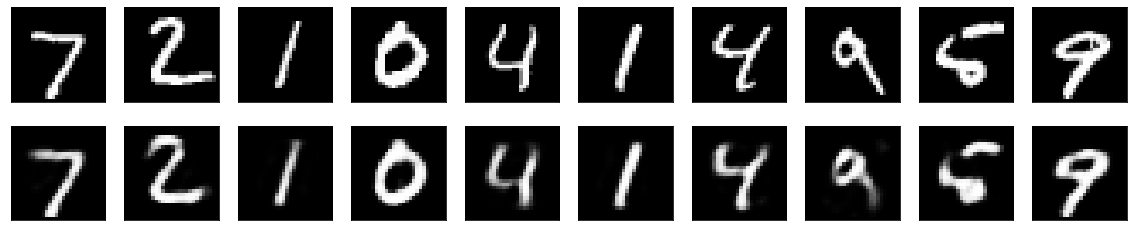

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
